# Conditional Autoencoder for Asset Pricing - Part 1: The Data

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [5]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Data

### Prices

In [6]:
prices = pd.read_hdf(results_path / 'data.h5', 'stocks/prices/adjusted')

In [7]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15771439 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZYXI', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   close   15771439 non-null  float64
 1   high    15771439 non-null  float64
 2   low     15771439 non-null  float64
 3   open    15771439 non-null  float64
 4   volume  15771439 non-null  float64
dtypes: float64(5)
memory usage: 662.7+ MB


### Metadata

In [8]:
metadata = pd.read_hdf(results_path / 'data.h5', 'stocks/info').rename(columns=str.lower)

In [9]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7690 entries, A to ZYXI
Columns: 143 entries, address1 to openinterest
dtypes: float64(112), object(31)
memory usage: 8.4+ MB


### Select tickers with metadata

In [10]:
sectors = (metadata.sector.value_counts() > 50).index

In [11]:
tickers_with_errors = ['FTAI', 'AIRT', 'CYBR', 'KTB']

In [12]:
tickers_with_metadata = metadata[metadata.sector.isin(sectors) & 
                                 metadata.marketcap.notnull() &
                                 metadata.sharesoutstanding.notnull() & 
                                (metadata.sharesoutstanding > 0)].index.drop(tickers_with_errors)

In [13]:
metadata = metadata.loc[tickers_with_metadata, ['sector', 'sharesoutstanding', 'marketcap']]
metadata.index.name = 'ticker'

In [14]:
prices = prices.loc[idx[tickers_with_metadata, :], :]

C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\626631212.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  prices = prices.loc[idx[tickers_with_metadata, :], :]


In [15]:
prices.info(null_counts=True)

C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\2816293840.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  prices.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15556089 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZYXI', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   close   15556089 non-null  float64
 1   high    15556089 non-null  float64
 2   low     15556089 non-null  float64
 3   open    15556089 non-null  float64
 4   volume  15556089 non-null  float64
dtypes: float64(5)
memory usage: 653.7+ MB


In [16]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6318 entries, A to ZYXI
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sector             6318 non-null   object 
 1   sharesoutstanding  6318 non-null   float64
 2   marketcap          6318 non-null   float64
dtypes: float64(2), object(1)
memory usage: 197.4+ KB


In [17]:
close = prices.close.unstack('ticker').sort_index()
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7559 entries, 1990-01-02 to 2019-12-31
Columns: 3825 entries, A to ZYXI
dtypes: float64(3825)
memory usage: 220.6 MB


In [18]:
volume = prices.volume.unstack('ticker').sort_index()
volume.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7559 entries, 1990-01-02 to 2019-12-31
Columns: 3825 entries, A to ZYXI
dtypes: float64(3825)
memory usage: 220.6 MB


### Create weekly returns

In [19]:
returns = (prices.close
           .unstack('ticker')
           .resample('W-FRI').last()
           .sort_index().pct_change().iloc[1:])
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1565 entries, 1990-01-12 to 2020-01-03
Freq: W-FRI
Columns: 3825 entries, A to ZYXI
dtypes: float64(3825)
memory usage: 45.7 MB


In [20]:
dates = returns.index

C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\2988771377.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returns.count(1), kde=False);


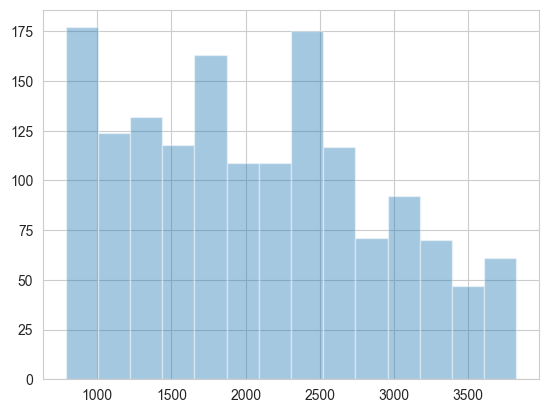

In [21]:
sns.distplot(returns.count(1), kde=False);

In [22]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    store.put('close', close)
    store.put('volume', volume)
    store.put('returns', returns)
    store.put('metadata', metadata)

## Factor Engineering

In [23]:
MONTH = 21

### Price Trend

#### Short-Term Reversal

1-month cumulative return

In [24]:
dates[:5]

DatetimeIndex(['1990-01-12', '1990-01-19', '1990-01-26', '1990-02-02',
               '1990-02-09'],
              dtype='datetime64[ns]', name='date', freq='W-FRI')

In [25]:
mom1m = close.pct_change(periods=MONTH).resample('W-FRI').last().stack().to_frame('mom1m')
mom1m.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3210620 entries, (Timestamp('1990-02-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   mom1m   float64
dtypes: float64(1)
memory usage: 36.9+ MB


In [26]:
mom1m.squeeze().to_hdf(results_path / 'autoencoder.h5', 'factor/mom1m')

#### Stock Momentum

11-month cumulative returns ending 1-month before month end

In [27]:
mom12m = (close
            .pct_change(periods=11 * MONTH)
            .shift(MONTH)
            .resample('W-FRI')
            .last()
            .stack()
            .to_frame('mom12m'))

In [28]:
mom12m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3032594 entries, (Timestamp('1991-01-04 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mom12m  3032594 non-null  float64
dtypes: float64(1)
memory usage: 34.9+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\734250054.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mom12m.info(null_counts=True)


In [29]:
mom12m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom12m')

#### Momentum Change

Cumulative return from months t-6 to t-1 minus months t-12 to t-7.

In [30]:
chmom = (close
         .pct_change(periods=6 * MONTH)
         .sub(close.pct_change(periods=6 * MONTH).shift(6 * MONTH))
         .resample('W-FRI')
         .last()
         .stack()
         .to_frame('chmom'))

In [31]:
chmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3032594 entries, (Timestamp('1991-01-04 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   chmom   3032594 non-null  float64
dtypes: float64(1)
memory usage: 34.9+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\480465195.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  chmom.info(null_counts=True)


In [32]:
chmom.to_hdf(results_path / 'autoencoder.h5', 'factor/chmom')

#### Industry Momentum

Equal-weighted avg. industry 12-month returns

In [33]:
indmom = (close.pct_change(12*MONTH)
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('close')
          .join(metadata[['sector']]).groupby(['date', 'sector'])
          .close.mean()
          .to_frame('indmom')
          .reset_index())

In [34]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18168 entries, 0 to 18167
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    18168 non-null  datetime64[ns]
 1   sector  18168 non-null  object        
 2   indmom  18168 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 425.9+ KB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\949876339.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  indmom.info(null_counts=True)


In [35]:
indmom = (returns
          .stack()
          .to_frame('ret')
          .join(metadata[['sector']])
          .reset_index()
          .merge(indmom)
          .set_index(['date', 'ticker'])
          .loc[:, ['indmom']])

In [36]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3182400 entries, (Timestamp('1991-01-04 00:00:00'), 'AA') to (Timestamp('2020-01-03 00:00:00'), 'ZTR')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   indmom  3182400 non-null  float64
dtypes: float64(1)
memory usage: 36.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\949876339.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  indmom.info(null_counts=True)


In [37]:
indmom.to_hdf(results_path / 'autoencoder.h5', 'factor/indmom')

#### Recent Max Return

Max daily returns from calendar month t-1

In [38]:
maxret = (close
           .pct_change(periods=MONTH)
           .rolling(21)
           .max()
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('maxret'))

In [39]:
maxret.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3194850 entries, (Timestamp('1990-03-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   maxret  3194850 non-null  float64
dtypes: float64(1)
memory usage: 36.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\180646522.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  maxret.info(null_counts=True)


In [40]:
maxret.to_hdf(results_path / 'autoencoder.h5', 'factor/maxret')

#### Long-Term Reversal

Cumulative returns months t-36 to t-13.

In [41]:
mom36m = (close
           .pct_change(periods=24*MONTH)
           .shift(12*MONTH)
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('mom36m'))

In [42]:
mom36m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2676077 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mom36m  2676077 non-null  float64
dtypes: float64(1)
memory usage: 30.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\3570578006.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mom36m.info(null_counts=True)


In [43]:
mom36m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom36m')

### Liquidity Metrics

#### Turnover

Avg. monthly trading volume for most recent three months scaled by number of shares; we are using the most recent no of shares from yahoo finance

In [44]:
turn = (volume
        .rolling(3*MONTH)
        .mean()
        .resample('W-FRI')
        .last()
        .div(metadata.sharesoutstanding)
        .stack('ticker')
        .to_frame('turn'))

In [45]:
turn.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3178142 entries, (Timestamp('1990-03-30 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   turn    3178142 non-null  float64
dtypes: float64(1)
memory usage: 36.7+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\2727825691.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  turn.info(null_counts=True)


In [46]:
turn.to_hdf(results_path / 'autoencoder.h5', 'factor/turn')

#### Turnover Volatility

Monthly std dev of daily share turnover

In [47]:
turn_std = (prices
            .volume
            .unstack('ticker')
            .div(metadata.sharesoutstanding)
            .rolling(MONTH)
            .std()
            .resample('W-FRI')
            .last()
            .stack('ticker')
            .to_frame('turn_std'))

In [48]:
turn_std.to_hdf(results_path / 'autoencoder.h5', 'factor/turn_std')

#### Log Market Equity

Natural log of market cap at end of month t-1

In [49]:
last_price = close.ffill()
factor = close.div(last_price.iloc[-1])
mvel = np.log1p(factor.mul(metadata.marketcap).resample('W-FRI').last()).stack().to_frame('mvel')

In [50]:
mvel.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3227144 entries, (Timestamp('1990-01-05 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mvel    3227144 non-null  float64
dtypes: float64(1)
memory usage: 37.3+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\567849824.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mvel.info(null_counts=True)


In [51]:
mvel.to_hdf(results_path / 'autoencoder.h5', 'factor/mvel')

#### Dollar Volume

Natural log of trading volume time price per share from month t-2

In [52]:
dv = close.mul(volume)

In [53]:
dolvol = (np.log1p(dv.rolling(21)
                  .mean()
                  .shift(21)
                  .resample('W-FRI')
                  .last())
          .stack()
          .to_frame('dolvol'))

In [54]:
dolvol.to_hdf(results_path / 'autoencoder.h5', 'factor/dolvol')

#### Amihud Illiquidity

Average of daily (absolute return / dollar volume)

In [55]:
ill = (close.pct_change().abs()
       .div(dv)
       .rolling(21)
       .mean()
       .resample('W-FRI').last()
       .stack()
       .to_frame('ill'))

In [56]:
ill.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2880851 entries, (Timestamp('1990-02-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ill     2880851 non-null  float64
dtypes: float64(1)
memory usage: 33.2+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\1107602282.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  ill.info(null_counts=True)


In [57]:
ill.to_hdf(results_path / 'autoencoder.h5', 'factor/ill')

### Risk Measures

#### Return Volatility

Standard dev of daily returns from month t-1.

In [58]:
retvol = (close.pct_change()
          .rolling(21)
          .std()
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('retvol'))

In [59]:
retvol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3210620 entries, (Timestamp('1990-02-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   retvol  3210620 non-null  float64
dtypes: float64(1)
memory usage: 36.9+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\2042333437.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  retvol.info(null_counts=True)


In [60]:
retvol.to_hdf(results_path / 'autoencoder.h5', 'factor/retvol')

#### Market Beta

Estimated market beta from weekly returns and equal weighted market returns for 3 years ending month t-1 with at least 52 weeks of returns.

In [61]:
index = close.resample('W-FRI').last().pct_change().mean(1).to_frame('x')

In [62]:
def get_market_beta(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = RollingOLS(endog=df.y, 
                       exog=sm.add_constant(df[['x']]),
                      window=3*52)

    return model.fit(params_only=True).params['x']

In [63]:
beta = (returns.dropna(thresh=3*52, axis=1)
        .apply(get_market_beta).stack().to_frame('beta'))

In [64]:
beta.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2677781 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   beta    2677781 non-null  float64
dtypes: float64(1)
memory usage: 30.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\2943542198.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  beta.info(null_counts=True)


In [65]:
beta.to_hdf(results_path / 'autoencoder.h5', 'factor/beta')

#### Beta Squared

Market beta squared

In [66]:
betasq = beta.beta.pow(2).to_frame('betasq')

In [67]:
betasq.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2677781 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   betasq  2677781 non-null  float64
dtypes: float64(1)
memory usage: 30.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\1828334906.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  betasq.info(null_counts=True)


In [68]:
betasq.to_hdf(results_path / 'autoencoder.h5', 'factor/betasq')

#### Idiosyncratic return volatility

Standard dev of a regression of residuals of weekly returns on the returns of an equal weighted market index returns for the prior three years.

This takes a while!

In [69]:
def get_ols_residuals(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = sm.OLS(endog=df.y, exog=sm.add_constant(df[['x']]))
    result = model.fit()
    return result.resid.std()

In [70]:
# 오래 걸림
idiovol = (returns.apply(lambda x: x.rolling(3 * 52)
                         .apply(get_ols_residuals)))

In [71]:
idiovol = idiovol.stack().to_frame('idiovol')

In [72]:
idiovol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2677781 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   idiovol  2677781 non-null  float64
dtypes: float64(1)
memory usage: 30.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\1780519557.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  idiovol.info(null_counts=True)


In [73]:
idiovol.to_hdf(results_path / 'autoencoder.h5', 'factor/idiovol')